In [49]:
from nlp_ai_utils import *
from chunks_urls import CHUNKS_URLS
from updating_values import DATA_LIMIT
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [50]:
#set this variable to true if you are using light more, or false if you are using dark mode.
JUPYTER = False
RANDOM_STATE = 42

In [51]:
TF_ENABLE_ONEDNN_OPTS = 0
URLS = CHUNKS_URLS
LIMIT = DATA_LIMIT
LARGER_DATASET_PATH = "../larger_dataset"
PREPROCESSED_CHUNKS_PATH = LARGER_DATASET_PATH + "/data_chunks/"
BASE_FILE_NAME = "chunk_"
FILE_FORMAT = ".csv"
DATA_IN_CHUNK = 116505
if LIMIT == 60:
    ACTUAL_DATA_SHAPE = DATA_IN_CHUNK * LIMIT + 20
else:
    ACTUAL_DATA_SHAPE = DATA_IN_CHUNK * LIMIT
RANDOM_STATE = 42
USE_READY_DATA = False

### 1.1 Data Sourcing and Munging

#### 1.1.1 Utility Functions

In [52]:
if not os.path.exists(LARGER_DATASET_PATH):
    os.mkdir(LARGER_DATASET_PATH)
if not os.path.exists(PREPROCESSED_CHUNKS_PATH):
    os.mkdir(PREPROCESSED_CHUNKS_PATH)
get_chunks(URLS,LIMIT,1,BASE_FILE_NAME,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

chunk_1 already exists.
chunk_2 already exists.
chunk_3 already exists.
chunk_4 already exists.
chunk_5 already exists.
chunk_6 already exists.


In [53]:
#get all names of downloaded files
all_file_names = get_all_file_names(BASE_FILE_NAME,LIMIT)

In [54]:
#read all chunks into a list
list_dfs = read_chunks(all_file_names,PREPROCESSED_CHUNKS_PATH,FILE_FORMAT)

In [55]:
#concatenate all chunks into a singular df
df = group_up_chunks(list_dfs)

In [56]:
#check how much of the data was actually downloaded
percent_loaded = check_no_missing_data(df.shape[0],ACTUAL_DATA_SHAPE)
percent_loaded

100.0

In [57]:
df.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [58]:
review_data = df[['text', 'stars']].copy()

In [59]:
review_data

,text,stars
0,"If you decide to eat here, just be aware it is...",3.0
1,I've taken a lot of spin classes over the year...,5.0
2,Family diner. Had the buffet. Eclectic assortm...,3.0
3,"Wow! Yummy, different, delicious. Our favo...",5.0
4,Cute interior and owner (?) gave us tour of up...,4.0
...,...,...
116500,I'm so thrilled to discover this wonderful Fre...,5.0
116501,We were excited and hopeful to try this restau...,3.0
116502,We like to visit Gators when we are at Treasur...,4.0
116503,It was a cool night in New Orleans and I set u...,4.0


In [60]:
review_data.reset_index(inplace = True)
review_data.drop(['index'],axis = 1,inplace = True)

In [61]:
review_data.rename(columns = {'text':'full_review_text','stars':'star_rating'}, inplace = True)

In [62]:
review_data

,full_review_text,star_rating
0,"If you decide to eat here, just be aware it is...",3.0
1,I've taken a lot of spin classes over the year...,5.0
2,Family diner. Had the buffet. Eclectic assortm...,3.0
3,"Wow! Yummy, different, delicious. Our favo...",5.0
4,Cute interior and owner (?) gave us tour of up...,4.0
...,...,...
699025,I'm so thrilled to discover this wonderful Fre...,5.0
699026,We were excited and hopeful to try this restau...,3.0
699027,We like to visit Gators when we are at Treasur...,4.0
699028,It was a cool night in New Orleans and I set u...,4.0


In [63]:
review_data.isnull().sum()

full_review_text    0
star_rating         0
dtype: int64

In [64]:
review_data.dropna(inplace = True)

In [65]:
review_data['full_review_text'].replace('', np.nan, inplace=True)
review_data.dropna(inplace = True)

In [66]:
review_data['full_review_text'] = [new_text.lstrip('0123456789.- ') for new_text in review_data['full_review_text']]
review_data['full_review_text'] = [new_text.lstrip('s') for new_text in review_data['full_review_text']]

In [67]:
review_data['full_review_text'] = pd.Series([remove_stop_words(text.lower().translate(str.maketrans('', '', string.punctuation))) for text in review_data['full_review_text']])

In [68]:
words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in words or not w.isalpha())

In [69]:
review_data['full_review_text'] = review_data['full_review_text'].apply(clean_sent)

In [70]:
# Extract unique words from the text data
if USE_READY_DATA:
    if os.path.exists("../archived_files/pickle_files/unique_words.pickle"):
        unique_words = pickle.load(open("../archived_files/pickle_files/unique_words.pickle",'rb'))
    else:
        unique_words = set(' '.join(review_data['full_review_text']).split())
else:
    unique_words = set(' '.join(review_data['full_review_text']).split())

Text(0, 0.5, 'Word')

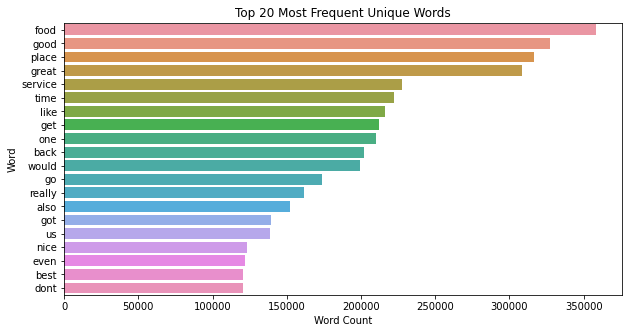

In [71]:
# Count the number of occurrences of each unique word and create a bar chart of the top 20 most frequent unique words
unique_word_count = review_data['full_review_text'].str.split(expand=True).stack().value_counts()
top_unique_words = unique_word_count.loc[unique_word_count.index.isin(unique_words)].head(20)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_unique_words.values, y=top_unique_words.index)
plt.title('Top 20 Most Frequent Unique Words')
plt.xlabel('Word Count')
plt.ylabel('Word')

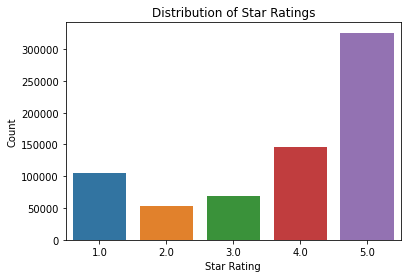

In [72]:
# Create a countplot of the star ratings using Seaborn
sns.countplot(x=review_data['star_rating'])

# Add some labels and titles
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Distribution of Star Ratings')

# Show the plot
plt.show()

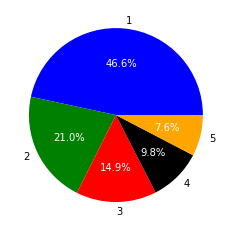

In [73]:
# Using a pieplot to visualize the star ratings
visualize_ratings_pie(review_data['star_rating'],1,5)

In [76]:
# Creating a Histogram of word lengths
word_lengths = review_data['full_review_text'].str.split().apply(lambda x: [len(word) for word in x])
word_lengths = [length for sublist in word_lengths for length in sublist]
plt.figure(figsize=(10, 6))
plt.hist(word_lengths, bins=100, edgecolor='black')
plt.title('Histogram of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
sid = SentimentIntensityAnalyzer()
sent_polarity_words = [sid.polarity_scores(word) for word in unique_words]

In [ ]:
word_sentiments = []

In [ ]:
word_frequencies = {'Positive': {}, 'Negative': {}, 'Neutral': {}}

In [ ]:
for i,word in enumerate(unique_words):
    if sent_polarity_words[i]['compound'] > 0:
        word_sentiments.append((word, 'Positive'))
    elif sent_polarity_words[i]['compound'] < 0:
        word_sentiments.append((word, 'Negative'))       
    else:
        word_sentiments.append((word, 'Neutral'))

In [ ]:
for word, sentiment in word_sentiments:
    if word in word_frequencies[sentiment]:
        word_frequencies[sentiment][word] += 1
    else:
        word_frequencies[sentiment][word] = 1

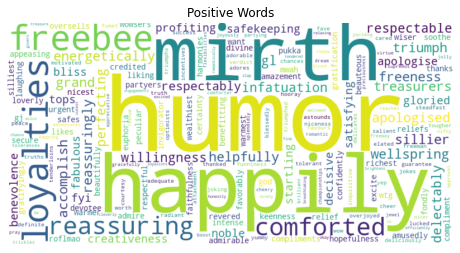

In [ ]:
# Generate word cloud for positive sentiment
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies['Positive'])

# Plot the positive word cloud
plt.figure(figsize=(8, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')
plt.show()

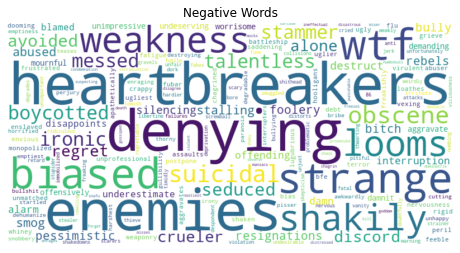

In [ ]:
# Generate word cloud for negative sentiment
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies['Negative'])

# Plot the negative word cloud
plt.figure(figsize=(8, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()

In [ ]:
# Generate word cloud for neutral sentiment
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies['Neutral'])

# Plot the neutral word cloud
plt.figure(figsize=(8, 6))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Neutral Words')
plt.show()